# Baseline Model

In [8]:
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, StratifiedKFold
# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score


# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

import pickle

#display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

path = '/home/jln436/Internship_AUMC/'

## Load the data

In [2]:
random_seed = 42

In [3]:
# Load testing sets
df = pd.read_csv(path + 'output/dfs/X_test_final.csv')
target = pd.read_csv(path + 'output/dfs/y_test_final.csv')
# Get df_train for scaling the testing dataset
df_train = pd.read_csv(path + 'output/dfs/X_train_final.csv')
y_train = pd.read_csv(path + 'output/dfs/y_train_final.csv')
# Get no cognitive function datasets
df_train_nc = pd.read_csv(path + 'output/dfs/X_train_final_minus.csv')
df_nc = pd.read_csv(path + 'output/dfs/X_test_final_minus.csv')

In [4]:
# Remove id number because not useful for predictions
df.drop(columns = ['respnr'], inplace = True)
df_train.drop(columns = ['respnr'], inplace = True)
df_nc.drop(columns = ['respnr'], inplace = True)
df_train_nc.drop(columns = ['respnr'], inplace = True)

In [5]:
#Scale features
scaler = StandardScaler()
scaler.fit(df_train)
df_train = pd.DataFrame(scaler.transform(df_train), columns = df_train.columns)
df = pd.DataFrame(scaler.transform(df), columns = df.columns)
#Scale features
scaler2 = StandardScaler()
scaler2.fit(df_train_nc)
df_train_nc = pd.DataFrame(scaler2.transform(df_train_nc), columns = df_train_nc.columns)
df_nc = pd.DataFrame(scaler2.transform(df_nc), columns = df_nc.columns)

## Perform Forward Selection

In [40]:
lreg = LinearRegression()
sfs1 = sfs(lreg, n_features_to_select='auto', direction='forward', tol = 0.01, scoring='neg_root_mean_squared_error')
sfs1 = sfs1.fit(df_train, y_train)
feat_names = sfs1.feature_names_in_[list(np.where(sfs1.get_support())[0])]
print(feat_names)
print(len(feat_names))

['bmcodt_mean' 'balcos10' 'bcesd15' 'bcara06' 'bcva10' 'bdiabe04'
 'bhart13' 'brheum11' 'bcardig7' 'bqseff08' 'bmalcnr' 'bmpeakfu' 'bmtmax'
 'blphya19' 'bpartst_spouse_oh' 'bage']
16


In [44]:
lreg_nc = LinearRegression()
sfs1_nc = sfs(lreg_nc, n_features_to_select='auto', direction='forward', tol = 0.01, scoring='neg_root_mean_squared_error')
sfs1_nc = sfs1_nc.fit(df_train_nc, y_train)
feat_names_nc = sfs1_nc.feature_names_in_[list(np.where(sfs1_nc.get_support())[0])]
print(feat_names_nc)
print(len(feat_names_nc))

['bincdecl' 'balcos09' 'banxiet6' 'bcance5k' 'bcancer4' 'bcancer8'
 'bothsi11' 'brheum07' 'bhealth3' 'bcardig4' 'bwalk01' 'bwalk03' 'bwalk05'
 'blo_sum' 'bqfood03' 'bmpeakf1' 'bmpeakfu' 'bmweightch' 'bmbenanx'
 'bsatis' 'bhdependent' 'bhtype_other' 'badl6b' 'bsense03' 'blphya08'
 'blphya10' 'blphya24' 'bhob' 'bmsmokepm' 'Bmir'
 'bpartst_partner_opp_sex_oh' 'sex' 'aeducat' 'b_DM' 'binccat' 'bage']


## Make baseline model

In [46]:
lm_baseline = LinearRegression()
lm_baseline.fit(df_train[feat_names], y_train)   
baseline_pred = lm_baseline.predict(df[feat_names])

In [47]:
# accuracy check
mse = mean_squared_error(target, baseline_pred)
rmse = mse**(0.5)
mae = mean_absolute_error(target, baseline_pred)
score = r2_score(target, baseline_pred)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 2.59
MSE: 10.50
RMSE: 3.24
R^2: 0.79


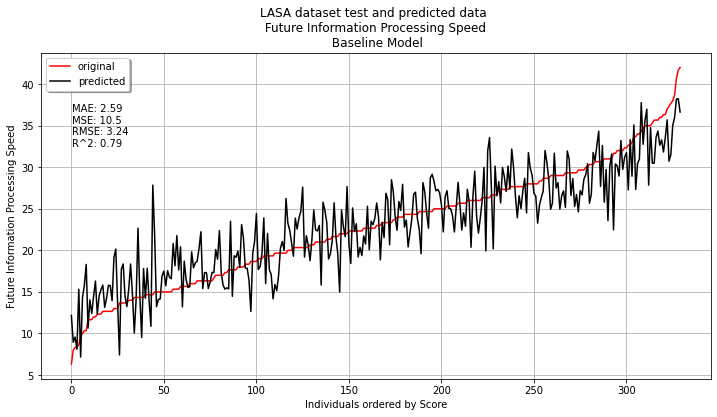

In [48]:
baseline = pd.DataFrame(data = target, columns = ['target'])
baseline['predicted'] = baseline_pred
baseline = baseline.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, baseline.target, label="original", color = "red")
plt.plot(x_ax, baseline.predicted, label="predicted", color = "black")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Baseline Model")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

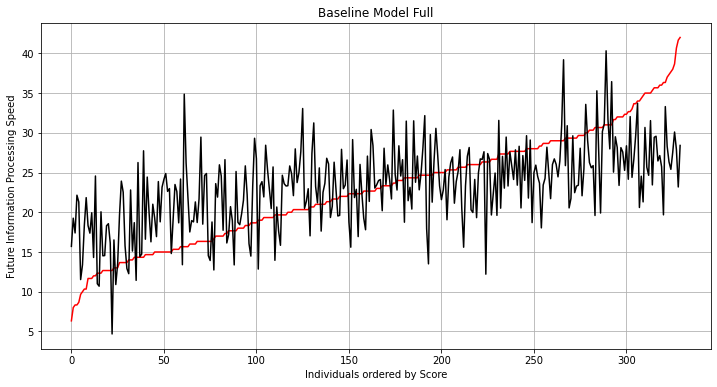

In [62]:
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, baseline.target, label="original", color = "red")
plt.plot(x_ax, baseline.predicted, label="predicted", color = "black")
plt.title("Baseline Model Full")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/baseline_full.png')

In [49]:
lm_baseline = LinearRegression()
lm_baseline.fit(df_train_nc[feat_names_nc], y_train)   
baseline_pred = lm_baseline.predict(df[feat_names_nc])

In [50]:
# accuracy check
mse = mean_squared_error(target, baseline_pred)
rmse = mse**(0.5)
mae = mean_absolute_error(target, baseline_pred)
score = r2_score(target, baseline_pred)
print("MAE: %.2f" % mae)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)
print("R^2: %.2f" % score)

MAE: 4.80
MSE: 36.33
RMSE: 6.03
R^2: 0.26


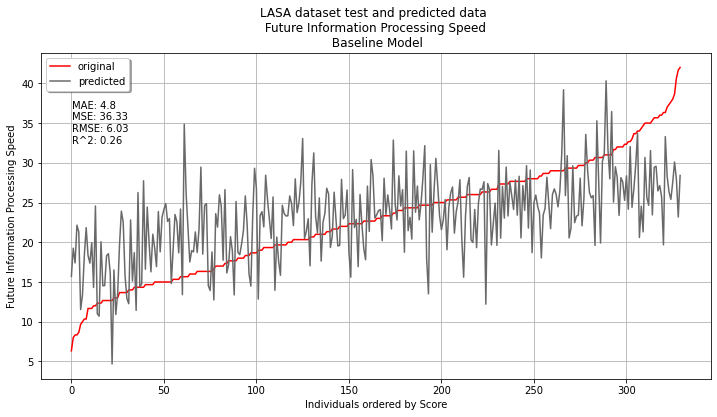

In [54]:
baseline = pd.DataFrame(data = target, columns = ['target'])
baseline['predicted'] = baseline_pred
baseline = baseline.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, baseline.target, label="original", color = "red")
plt.plot(x_ax, baseline.predicted, label="predicted", color = "dimgrey")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Baseline Model")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 32.5, 'MAE: ' + str(round(mae,2)) + '\nMSE: ' + str(round(mse,2)) + '\nRMSE: ' + str(round(rmse,2)) + '\nR^2: ' + str(round(score,2)), fontsize = 10)
plt.show()

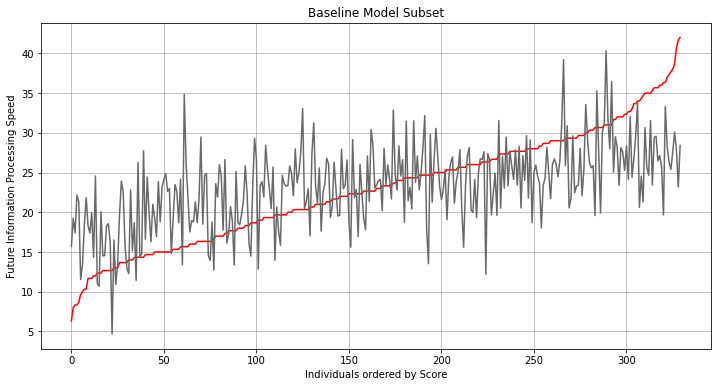

In [63]:

# visualizing in a plot
x_ax = range(len(target))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, baseline.target, label="original", color = "red")
plt.plot(x_ax, baseline.predicted, label="predicted", color = "dimgrey")
plt.title("Baseline Model Subset")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.grid(True)
plt.savefig(path + '/output/plots/baseline_subset.png')